In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import keras
from keras.models import Sequential, load_model
from plot_conf import *
import shelve
import h5py
import math
import matplotlib.colors as colors
import scipy
import dashi as d

Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:


def energyResolutionGary(predicted, target, weights, Ebins):
    #https://arxiv.org/pdf/1311.4767.pdf
    e_reco_bins = Ebins                                                                                                                          
    e_true_bins = Ebins                                                                                                 
    h_pred = d.factory.hist2d((predicted,target), bins=(e_reco_bins, e_true_bins), weights=weights)                                                                
    ffunc = lambda x, loc, scale, norm : norm*scipy.stats.norm.pdf(x,loc,scale)                                                                                 
    stds_per_energy = []
    for i in xrange(h_pred.bincontent.shape[1]):
        h_pred = d.factory.hist2d((predicted,target), 
                                  bins=(e_reco_bins,e_true_bins),
                                  weights=np.ones(len(target)))                                                                   
        h_slice = h_pred[:,i]                                                                                                                                   
        h_pred.bincontent = h_pred.bincontent * h_slice.bincontent[:,np.newaxis]                                                                                 
        hs = h_pred.bincontent.sum(axis=0)                                                                                                                      
        if hs.sum() != 0:
            hs = hs / hs.sum()                                                                                                                                  
        nan_mask = ~np.isnan(hs)                                                                                                                                 
        ppar, pcov = scipy.optimize.curve_fit(ffunc,
                                              h_pred.bincenters[1][nan_mask],
                                              hs[nan_mask],
                                              p0=[h_slice.bincenters[i],0.2,1])
        stds_per_energy.append(ppar[1])                                                                                                                         
    return h_pred.bincenters[1], stds_per_energy



In [3]:
basepath = '/Users/theoglauch/slimfast/NN_Reco/train_hist/lowE_hexgrid/2017-09-03-10-27-12/'
plot_data = np.load(os.path.join(basepath, 'test_res.npy'))
xbins = np.linspace(1.5,7,35)
ybins = np.linspace(0,9,35)
resolution=[]
gary_resolution = []
binmids_x = [(xbins[i+1]+xbins[i])/2 for i in range(len(xbins)-1)]
binmids_y = [(ybins[i+1]+ybins[i])/2 for i in range(len(ybins)-1)]

In [4]:
x=np.log10(plot_data['depositedE_truth'])
y=[np.log10(plot_data['muex_truth']), plot_data['depositedE']] 
save_names= ['MuEx', 'DLReco']

In [14]:
which = 1
save = True

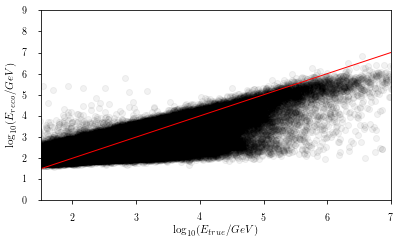

In [15]:
fig, ax= newfig(0.9)
ax.scatter(x, y[which], color='black', alpha= 0.05)
ax.plot(xbins, xbins, color='red')
ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$')
ax.set_ylabel(r'$\log_{10}(E_{reco}/GeV)$')
ax.set_xlim(xbins[0],xbins[-1])
ax.set_ylim(ybins[0],ybins[-1])
if save:
    plt.savefig('{}_scatter.png'.format(save_names[which]), dpi=300)
plt.show()

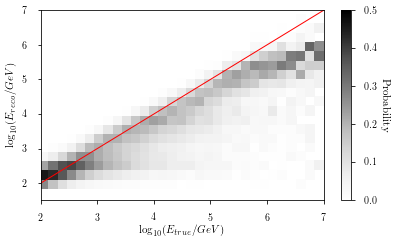

In [16]:
H, xedges, yedges = np.histogram2d(x,
                                   y[which], 
                                   bins=(xbins, ybins))
H=np.array([np.array(i)/np.sum(i) if np.sum(i)!= 0 else np.zeros(len(i)) for i in H ])
H = H.T  # Let each row list bins with common y range.
fig, ax = newfig(0.9)
X, Y = np.meshgrid(xedges, yedges)
ax.plot(xbins,
        xbins,
        color='red')

plot_H= np.ma.array(H)
plot_H.mask = (plot_H == 0) | (plot_H>1.0)
cbar = ax.pcolormesh(X, Y, plot_H, cmap=plt.get_cmap('Greys'))
#norm=colors.LogNorm(vmin=plot_H.min(), vmax=1.)
cbar.set_clim(0.0, 0.5)

cb = plt.colorbar(cbar)
cb.set_label('Probability', labelpad=14, rotation= 270)
ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$')
ax.set_ylabel(r'$\log_{10}(E_{reco}/GeV)$')
ax.set_ylim(1.5,7)
ax.set_xlim(2,7)
if save:
    plt.savefig('{}_PDF.png'.format(save_names[which]), dpi=300)
plt.show()




In [12]:
temp_resolution = []
for i, binmid in enumerate(binmids_x):
    average = np.average(binmids_y, weights=H.T[i])
    std = math.sqrt(np.average((binmids_y-average)**2, weights=H.T[i]))
    temp_resolution.append(std/binmid)
gary_resolution.append((save_names[which], energyResolutionGary(y[which], x, np.ones(len(x)), xbins)[1]))
resolution.append((save_names[which],temp_resolution))

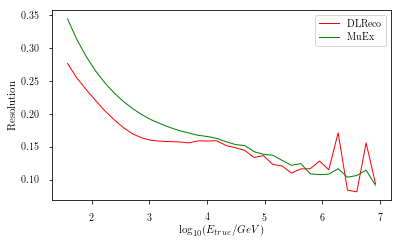

In [13]:
fig, ax= newfig(0.9)
for reco in gary_resolution:#resolution:
    ax.plot(binmids_x, np.array(reco[1])/np.array(binmids_x), label=reco[0])
    ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$')
    ax.set_ylabel(r'Resolution')
ax.legend(loc='best')
if save:
    plt.savefig('resolution.pdf',)
plt.show()

# Angle Reco

In [44]:
basepath = '/Users/theoglauch/slimfast/NN_Reco/train_hist/angle_reco/2017-08-24-19-14-58'
angle = 'azimuth'
plot_data = np.load(os.path.join(basepath, 'test_res.npy'))
if angle == 'azimuth':
    xbins = np.linspace(0,2*np.pi,50)
    ybins = np.linspace(0,2*np.pi,50)
elif angle == 'zenith':
    xbins = np.linspace(0,np.pi,50)
    ybins = np.linspace(0,np.pi,50)
else:
    raise Exception('angle not defined')
resolution=[]
gary_resolution = []
binmids_x = [(xbins[i+1]+xbins[i])/2 for i in range(len(xbins)-1)]
binmids_y = [(ybins[i+1]+ybins[i])/2 for i in range(len(ybins)-1)]

In [45]:
x=plot_data['{}_truth'.format(angle)]
y=plot_data['{}'.format(angle)]
save_names= ['Angle_DLReco']
save = False

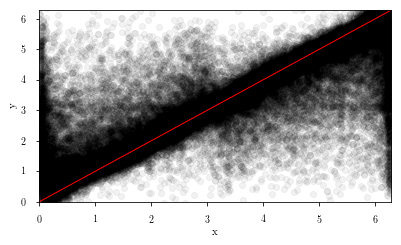

In [46]:
fig, ax= newfig(0.9)
ax.scatter(x, y, color='black', alpha= 0.05)
ax.plot(xbins, xbins, color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(xbins[0],xbins[-1])
ax.set_ylim(ybins[0],ybins[-1])
if save:
    plt.savefig('{}_{}_scatter.png'.format(angle,save_names), dpi=300)
plt.show()

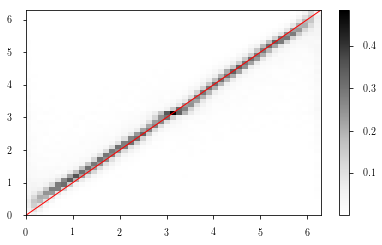

In [47]:
H, xedges, yedges = np.histogram2d(x,
                                   y, 
                                   bins=(xbins, ybins))
H=np.array([np.array(i)/np.sum(i) if np.sum(i)!= 0 else np.zeros(len(i)) for i in H ])
H = H.T  # Let each row list bins with common y range.
fig, ax = newfig(0.9)
X, Y = np.meshgrid(xedges, yedges)
ax.plot(xbins,
        xbins,
        color='red')

plot_H= np.ma.array(H)
plot_H.mask = (plot_H == 0) | (plot_H>1.0)
cbar = ax.pcolormesh(X, Y, plot_H, cmap=plt.get_cmap('Greys'))
#norm=colors.LogNorm(vmin=plot_H.min(), vmax=1.)
plt.colorbar(cbar)
# ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$')
# ax.set_ylabel(r'$\log_{10}(E_{reco}/GeV)$')
ax.set_xlim(xbins[0],xbins[-1])
ax.set_ylim(ybins[0],ybins[-1])
if save:
    plt.savefig('{}_{}_PDF.png'.format(angle, save_names), dpi=300)
plt.show()

In [70]:
a = (11,21,61,1)

In [84]:
b = a[:-1]+(2,)

In [85]:
print b

(11, 21, 61, 2)
